In [1]:
!mkdir /content/model
!mkdir /content/model/critic
!mkdir /content/model/actor

mkdir: cannot create directory ‘/content/model’: File exists
mkdir: cannot create directory ‘/content/model/critic’: File exists
mkdir: cannot create directory ‘/content/model/actor’: File exists


In [2]:
import numpy as np
import pandas as pd 
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm

In [3]:
s = np.random.uniform(-2,2,5000)
t = np.random.uniform(0,5,5000)
S = np.vstack((s,t)).T

In [4]:
S = torch.Tensor(S)

In [5]:
class Neural(nn.Module):
    def __init__(self):
        super(Neural,self).__init__()
        self.fc1 = nn.Linear(2,8,bias=True)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
critic_model = Neural()
actor_model = Neural()
criterion_critic = torch.nn.MSELoss()
optimizer_critic = torch.optim.Adam(critic_model.parameters(),lr = 0.002)
criterion_actor = torch.nn.MSELoss()
optimizer_actor = torch.optim.Adam(actor_model.parameters(),lr = 0.002)

In [7]:
def model_step(s,u,t):
    Step = 0.05
    s_new = s + Step*(0.2*(2+torch.sin(0.3*t*s))*s+u)
    t_new = t + Step
    return s_new,t_new

In [8]:
def initial_control(s,t):
    u = -2*s-0.2*torch.sin(0.3*t*s)*s
    return u

In [18]:
s_initial = torch.Tensor([1.0])
t_initial = torch.Tensor([0])
ss = []
ts = []
us = []
ss.append(s_initial)
ts.append(t_initial)
s_old = s_initial
t_old = t_initial
for i in range(100):
    u_curr = initial_control(s_old,t_old)
    us.append(u_curr)
    s_new,t_new = model_step(s_old,u_curr,t_old)
    ss.append(s_new)
    ts.append(t_new)
    s_old = s_new
    t_old = t_new

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


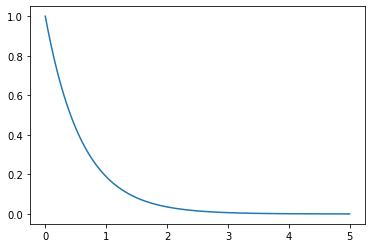

In [19]:
plt.plot(ts,ss)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


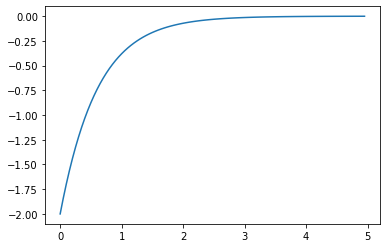

In [21]:
plt.plot(ts[:-1],us)
plt.show()

In [11]:
def V_function(s,t,mode = 'neural'):
    V = torch.Tensor([0.0])
    Step = 0.05
    s_old = s
    t_old = t
    for i in range(100):
        if mode == "custom":
            u_curr = initial_control(s_old,t_old)
        else:
            u_curr = Variable(actor_model(torch.hstack((s_old,t_old))),requires_grad = False)
        V += ((0.2*s**2+0.2*u_curr**2)*Step)
        s_new,t_new = model_step(s_old,u_curr,t_old)
        s_old = s_new
        t_old = t_new         
    return V


In [12]:
def train_critic(i):
    dataset_V = DataLoader(TensorDataset(S,V),batch_size = 1, shuffle = True)
    epochs = 50
    print(f"Train critic iterater {i}")
    for epoch in range(epochs):
        train_loss = 0
        critic_model.train()
        for idx, inp in enumerate(dataset_V):
            data,target = inp
            optimizer_critic.zero_grad()
            pred = critic_model(data)
            loss_V = criterion_critic(target,pred)
            loss_V.backward()
            optimizer_critic.step()
            train_loss += loss_V.item()
        print(f"Epoch {epoch+1}: MSE = {train_loss/len(dataset_V)}")
        if train_loss/len(dataset_V) < 1e-3:
            break
    PATH = f"/content/model/critic/model_critic_{i}.pkl"
    torch.save(critic_model.state_dict(),PATH)

In [13]:
def train_actor(iter):
    Y1 = critic_model.fc1.weight
    W1 = critic_model.fc2.weight
    b1 = critic_model.fc1.bias
    u_target = torch.zeros(len(S))
    Y11 = Y1[:,0]
    for i in range(len(S)):
        u_target[i] = -2.5*W1@(Y11*(1-(torch.tanh(Y1@torch.Tensor(S[i])+b1))**2))
    u_target = torch.autograd.Variable(torch.Tensor(u_target),requires_grad = False)
    dataset_u = DataLoader(TensorDataset(S,u_target),batch_size = 1, shuffle = True)
    epochs = 50
    print(f"Train actor iterater {iter}")
    for epoch in range(epochs):
        train_loss = 0
        actor_model.train()
        for idx, inp in enumerate(dataset_u):
            data,target = inp
            optimizer_actor.zero_grad()
            pred = actor_model(data)
            loss_u = criterion_actor(target,pred)
            loss_u.backward()
            optimizer_actor.step()
            train_loss += loss_u.item()
        print(f"Epoch {epoch+1}: MSE = {train_loss/len(dataset_u)}")
        if train_loss/len(dataset_u) < 1e-3:
            break
    PATH = f"/content/model/actor/model_actor_{iter}.pkl"
    torch.save(actor_model.state_dict(),PATH)

In [14]:
for iterater in range(3):
    V = torch.zeros(5000)
    for i in tqdm(range(5000)):
        if iterater == 0:
            V[i] = V_function(S[i,0],S[i,1],mode = "custom")
        else:
            V[i] = V_function(S[i,0],S[i,1],mode = "neural")
    train_critic(iterater)
    train_actor(iterater)



100%|██████████| 5000/5000 [00:55<00:00, 89.67it/s] 
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train critic iterater 0
Epoch 1: MSE = 1.5744213316840843
Epoch 2: MSE = 0.13844793698070842
Epoch 3: MSE = 0.023262284449759793
Epoch 4: MSE = 0.014614925735202677
Epoch 5: MSE = 0.011495345485500076
Epoch 6: MSE = 0.00974963522429365
Epoch 7: MSE = 0.008304273238545039
Epoch 8: MSE = 0.007381847539571845
Epoch 9: MSE = 0.006831759616261557
Epoch 10: MSE = 0.005976938591949476
Epoch 11: MSE = 0.0054752011441189935
Epoch 12: MSE = 0.005424288620138547
Epoch 13: MSE = 0.004874579460681544
Epoch 14: MSE = 0.004703670757404319
Epoch 15: MSE = 0.004377970391397512
Epoch 16: MSE = 0.004252018351734404
Epoch 17: MSE = 0.0040782662867694655
Epoch 18: MSE = 0.0038671523481473655
Epoch 19: MSE = 0.0038800351948357573
Epoch 20: MSE = 0.0035750572610126364
Epoch 21: MSE = 0.0036266017113831908
Epoch 22: MSE = 0.0037449464916494164
Epoch 23: MSE = 0.0033127918364546935
Epoch 24: MSE = 0.0034211285842847567
Epoch 25: MSE = 0.003358314429162506
Epoch 26: MSE = 0.003239438764543035
Epoch 27: MSE = 0.

100%|██████████| 5000/5000 [01:07<00:00, 74.04it/s]


Train critic iterater 1
Epoch 1: MSE = 0.010976715547269138
Epoch 2: MSE = 0.004778858537383203
Epoch 3: MSE = 0.0047431731938510635
Epoch 4: MSE = 0.0044256539962409
Epoch 5: MSE = 0.004355738081571288
Epoch 6: MSE = 0.004271150921240449
Epoch 7: MSE = 0.0043306999471446304
Epoch 8: MSE = 0.004138095915799414
Epoch 9: MSE = 0.0040456484422103775
Epoch 10: MSE = 0.0037853708146673277
Epoch 11: MSE = 0.0038488259593176034
Epoch 12: MSE = 0.0035403772958020226
Epoch 13: MSE = 0.003670772332354873
Epoch 14: MSE = 0.0035533689839679326
Epoch 15: MSE = 0.0036209996370813683
Epoch 16: MSE = 0.0032087643675937456
Epoch 17: MSE = 0.0033135020922564324
Epoch 18: MSE = 0.0034208792060050784
Epoch 19: MSE = 0.003341626985443827
Epoch 20: MSE = 0.003216127171694032
Epoch 21: MSE = 0.0032681312882324237
Epoch 22: MSE = 0.0034170340130774044
Epoch 23: MSE = 0.00298182910153359
Epoch 24: MSE = 0.0037256251550752575
Epoch 25: MSE = 0.0032746106895969254
Epoch 26: MSE = 0.0029495480513050155
Epoch 27: 

100%|██████████| 5000/5000 [01:07<00:00, 73.97it/s]


Train critic iterater 2
Epoch 1: MSE = 0.00552031677015366
Epoch 2: MSE = 0.004457828096415741
Epoch 3: MSE = 0.004153753713454558
Epoch 4: MSE = 0.0043273597746191226
Epoch 5: MSE = 0.0039497956720414475
Epoch 6: MSE = 0.004136741523630528
Epoch 7: MSE = 0.004103099874615994
Epoch 8: MSE = 0.0043273654110368735
Epoch 9: MSE = 0.004172633746765928
Epoch 10: MSE = 0.003943041407782332
Epoch 11: MSE = 0.004511127856538513
Epoch 12: MSE = 0.0037556027184316547
Epoch 13: MSE = 0.0039541867797237935
Epoch 14: MSE = 0.003976343250465024
Epoch 15: MSE = 0.004537422905556418
Epoch 16: MSE = 0.003930282257202531
Epoch 17: MSE = 0.004198037202246541
Epoch 18: MSE = 0.003839797887534423
Epoch 19: MSE = 0.0038995971277853685
Epoch 20: MSE = 0.004098374040069312
Epoch 21: MSE = 0.004014950824150138
Epoch 22: MSE = 0.0038185551587876787
Epoch 23: MSE = 0.004293671575197614
Epoch 24: MSE = 0.0037785184918203998
Epoch 25: MSE = 0.004067745966784121
Epoch 26: MSE = 0.0039397923238548745
Epoch 27: MSE =

In [16]:
ss_data = {}
us_data = {}
for iterater in range(3):
    model = Neural()
    PATH = f"/content/model/actor/model_actor_{iterater}.pkl"
    model.load_state_dict(torch.load(PATH))
    s_initial = torch.Tensor([1.0])
    t_initial = torch.Tensor([0])
    ss_data[iterater] = []
    us_data[iterater] = []
    ts = []
    ss_data[iterater].append(s_initial)
    ts.append(t_initial)
    s_old = s_initial
    t_old = t_initial
    for i in range(100):
        u_curr = Variable(actor_model(torch.hstack((s_old,t_old))),requires_grad = False)
        us_data[iterater].append(u_curr)
        s_new,t_new = model_step(s_old,u_curr,t_old)
        ss_data[iterater].append(s_new)
        ts.append(t_new)
        s_old = s_new
        t_old = t_new

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


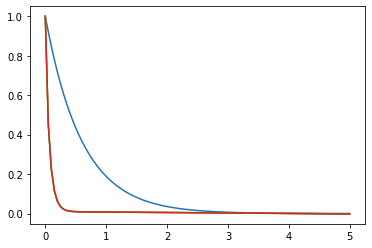

In [17]:
plt.plot(ts,ss)
plt.plot(ts,ss_data[0])
plt.plot(ts,ss_data[1])
plt.plot(ts,ss_data[2])

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


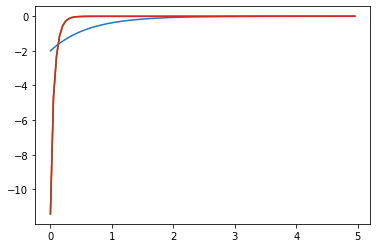

In [22]:
plt.plot(ts[:-1],us)
plt.plot(ts[:-1],us_data[0])
plt.plot(ts[:-1],us_data[1])
plt.plot(ts[:-1],us_data[2])